# Jeu du pendu

Dans cette partie nous utiliserons les instructions et techniques vues dans les deux précédentes parties afin d'écrire un jeu un peu plus complexe: Le pendu \[ *Hangman* \]. Cela demande d'implémenter la réalisation de graphique simple et d'avoir la capacité de manipuler des données qui représentent des caractères ASCII plutôt que juste des nombres.

## Graphique pixelisé en basse résolution

ARMlite fournie trois sortes de graphique pixelisé: basse résolution \[ *lo-res* \], moyenne résolution \[ *mid-res* \] et haute résolution \[ *hi-res* \]. Dans tous les cas, le graphique est dessiné dans un panneau dédié de la zone des entrées/sorties. Dans cette partie, nous utiliserons la basse résolution qui est de **32 x 24** pixels. Comme toutes les entrées/sorties de l'ARMLite, les graphiques pixelisé sont mappés en mémoire. Voici un exemple:

```
MOV R0, #.red
STR R0, .Pixel0
MOV R0, #0xffa503
STR R0, .Pixel32
HALT
```

Explications:
- ARMlite reconnaît plusieurs nom de couleurs prédéfinis comme `.red`; ils sont en minuscules. L'assembleur les traduit simplement en nombres dans le format RGB (rouge, vert, bleu) comme ceux utilisés en HTML. Du fait de la traduction en valeur immédiate, une couleur doit être précédée par `#` pour indiquer qu'elle doit être utilisée comme une valeur immédiate.
- Vous pouvez aussi fournir votre couleur RGB comme un nombre. La façon la plus commode de le faire est d'utiliser 6 chiffres hexadécimaux comme `#0xffa503` parce que les paires de chiffres précisent le niveau des composantes rouges, vertes et bleues.

#### Exercice 21

Saisir et faire tourner l'exemple ci-dessus - vous verrez deux pixels dessinés dans la zone graphique.

Étant donné qu'en basse résolution, l'affichage est une grille de 32x24 pixels, trouver les numéros des pixels des quatres coins de l'affichage et modifier le code de façon à dessiner chacun de ces pixels avec une couleur différente.

Faites une copie d'écran partielle montrant votre code et l'affichage obtenu.
____

Nous utiliserons cette possibilité pour dessiner la figure complète du pendu, quelquechose comme cela:

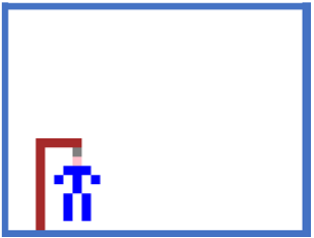

Dans le jeu, nous aurons besoin de dessiner la figure progressivement, selon le nombre de lettres fausses saisies par le joueur qui cherche à deviner le mot. Le code qui suit montre un *motif de programmation* pour cela, en montrant juste les deux premières parties de la figure - la potence et son «bras»:

```
//R0 multiple usages 
//R8 nombre de lettres incorrectes
  MOV R8, #10
drawPic:
  CMP R8, #1
  BLT endDraw
  MOV R0, #.brown
  STR R0, .Pixel739 //potence
  STR R0, .Pixel707
  STR R0, .Pixel675
  STR R0, .Pixel643
  STR R0, .Pixel611
  STR R0, .Pixel579
  STR R0, .Pixel547
  STR R0, .Pixel515
  STR R0, .Pixel483
  STR R0, .Pixel451
  CMP R8, #2
  BLT endDraw
  STR R0, .Pixel452 //bras de potence
  STR R0, .Pixel452
  STR R0, .Pixel453
  STR R0, .Pixel454
  STR R0, .Pixel455
  CMP R8, #3
  BLT endDraw
//AFAIRE:
//Corde, Tete, Corps, Jambe gauche, Jambe droite, Bras gauche, Bras droit
endDraw:
  HALT
```

Remarques:
- Comme précédemment on commence par indiquer le rôle des registres généraux utilisés. `R0` est ici ré-utilisé à des fins diverses pendant le jeu (c'est très commun).
- `R8` mémorise le nombre de lettres en erreur. Dans cet exemple, nous l'initialisons à 10 (afin de dessiner en effet la potence complète); plus tard, il sera déterminé par la logique du jeu.
- Avant de commencer une portion de dessin, nous comparons la valeur de `R8` à 1 puis 2 et ainsi de suite. Si à un moment donné la valeur de `R8` est inférieure à l'un de ces nombres, l'exécution est déroutée vers l'étiquette `endDraw` qui à ce point suspend simplement le programme. 

#### Exercice 22

Faire touner le programme précédent et confirmer par vous-même qu'il dessine les deux premiers composants du dessin. Ensuite, modifier la valeur placée dans `R8` au démarrage de #10 à #1 de manière à confirmer que dans ce cas seul le premier composant est dessiné.

À présent, en suivant le même motif de programmation, créer votre propre version du dessin du pendu. Il n'a pas besoin de ressembler exactement à celui montré plus haut; il peut être plus large si vous le souhaiter. Mais de toute façon,
- il doit être formé de 9 composants au total
- et, pour le 10e choix incorrect (ce qui a pour effet de faire perdre le joueur), faire un petit changement au dessin de manière à signifier que la personne a été définitivement pendu (par exemple, en remplaçant le visage avec un pixel noir...)
- ne passer pas trop de temps là-dessus, il est toujours possible d'améliorer la qualité artistique du dessin plus tard.

Une fois terminé, tester votre programme en le faisant tourner avec différentes valeurs initiales pour `R8` afin de vous assurez que dans chaque cas le programme dessine le bon nombre de composants.

Prenez une capture d'écran montrant le dessin complet et une autre pour votre code (il se peut que vous ne puissiez pas montrer tout le code de la zone d'édition de l'ARMlite, il est donc préférable de copier le texte de code).

Enfin sauvegarder votre code (par exemple en *drawPic routine*) car vous aurez besoin d'insérer votre routine un plus tard dans le code que nous allons développer.
_________

Nous sommes à présent prêt pour en faire un jeu. Ce jeu est pour deux joueurs: l'un positionne le mot à deviner et l'autre cherche à le deviner, et ils devraient pouvoir changer de rôle à chaque recommencement.

Pour cette simple raison que nous allons devoir maintenir le mot secret dans un registre, nous sommes limité à quatre caractères et puisqu'un mot de trois caractères est moins intéressant (et aussi plus dur à trouver de manière surprenante) le jeu imposera que ce mot ait exactement quatre caractères.

Le code qui suit demande au joueur qui lance la partie de saisir un mot et le range en mémoire à une adresse ayant pour étiquette `secretWord`.

```
captureWord:
    MOV R0, #setter
    STR R0, .WriteString
    MOV R0, #secretWord
    STR R0, .ReadSecret
    HALT
setter: .ASCIZ "Questionneur: Saisir votre mot\n"
secretWord:
```

*Remarques*: `.ReadString` permettrait de lire une chaîne de caractère depuis le champ de saisie. `.ReadSecret` fait la même chose mais cache la saisie sur l'affichage - c'est souvent utilisé pour la saisie d'un mot de passe par exemple.

#### Exercice 23

Faire tourner ce code et vérifier que vous pouvez saisir le mot. La contrainte d'un mot de quatre caractères n'est pas vérifiée ici, mais il faudra jouer en suivant les règles.

Vous devriez être en mesure de repérer le mot secret, encodé par quatre valeur ASCII, qui a été copié en mémoire à l'adresse (à la fin du programme) associé à l'étique `secretWord`. (La manière avec laquelle l'ARMlite le présente à l'écran donne l'impression que l'ordre des lettres a été inversé, mais ne vous en inquiéter pas).

Faire une copie d'écran qui met en évidence la position en mémoire du mot secret en indiquant séparemment comment cela correspond aux valeurs ASCII des quatre caractères qui le forme.

Avoir le mot secret visible en mémoire permet à l'autre joueur - s'il est capable de mémoriser les valeurs ASCII - de deviner facilement chaque lettre! Pour éviter cela, juste au-dessus de la définition de l'étiquette `secretWord:`, insérer une nouvelle ligne:

```
.ALIGN 512
```

Cela a pour effet de déplacer la position du mot secret à la prochaine adresse mémoire divisble par 512=0x200, ce qui est juste au-delà de la zone visible de la mémoire.

Effectuer ce changement, faites tourner le programme et vérifier que vous ne pouvez plus apercevoir le mot secret dans la première page mémoire.

Ensuite, modifier le numéro de page mémoire à 002 (comme montré ci-dessous):

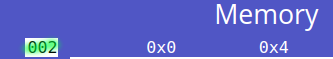

et faites une copie d'écran partielle qui montre la version encodée du mot saisi à sa nouvelle adresse mémoire `0x00020`.

Enfin, assurez-vous d'avoir remis la page mémoire à son numéro initial 000 pour la suite du jeu!
____________

Nous sommes à présent fin prêt pour le programme complet. Le code en lien est complet, excepté pour votre routine de dessin qu'il faudra insérer à la position indiqué en commentaire.

#### Exercice 24

Ouvrir le fichier pendu.txt puis y insérer votre routine `drawPic` à la place du commentaire qui vous demande de le faire. Remarquer que, plutôt que de suspendre l'exécution à l'étiquette `endDraw` le code se poursuit à présent, ainsi faites attention à ne pas dupliquer la définition de l'étiquette `endDraw`. Enregistrer le fichier à nouveau.

Charger le fichier complet et assurez-vous qu'il peut être validé et exécuté correctement.

À présent, modifier l'URL d'accès à l'ARMlite en y ajoutant, à la fin, la chaîne de requête (*query string*) `?profile=player`

    https://peterhigginson.co.uk/ARMlite/?profile=player
    
Cela va configurer l'ARMlite en affichant uniquement les éléments pertinents pour un joueur. Cela a malheureusement effacé le programme qu'il faudra de nouveau charger/exécuter.

Faites tourner le jeu et jouez-y avec un partenaire. N'oubliez pas que le mot secret doit comporter exactement quatre caractères.

Faites une copie d'écran de l'ARMlite en mode "player".

Ensuite, faites à nouveau tourner le jeu en mode pas à pas (lorsqu'une saisie utilisateur est en attente, saisir l'entrée puis valider "Enter" puis continuer en cliquant sur l'icone Single Step). Essayer de faire le maximum d'observation sur la façon dont le code fonctionne. Les commentaires en début de code sur le rôle des registres devraient beaucoup vous y aider.
_____

#### Exercice 25

Réfléchir aux façons d'améliorer ce programme en prenant la perspective de l'utilisateur et décrivez vos suggestions d'amélioration sur votre feuille de réponse (pas besoin de les implémenter ici).
____

Si vous aviez du temps, vous pourriez être tenter de mettre en oeuvre vos premières idées sur la façon d'améliorer le jeu.

Toutefois, l'amélioration la plus évidente - permettre au jeu de fonctionner avec des mots plus longs et de longueur variable - serait difficile à réaliser en utilisant seulement les instructions apprises jusqu'ici. Il serait possible de découper le mot pour qu'il tienne sur deux registres ou plus, mais le programme finirait par contenir beaucoup de code dupliqué.

D'autre part, vous avez pu être frustré d'avoir eu à préciser chaque pixel individuellement pour dessiner une ligne. Et, si vous souhaitiez déplacer votre dessin légèrement vers la droite (par exemple) vous seriez obligé de modifier chaque instruction qui écrit un pixel!

Vous pourriez-vous dire alors «bien programmer implique de généraliser» - et vous auriez raison. Ce dont nous avons vraiment besoin ici est un moyen pour pouvoir itérer sur une portion contigüe (*range*) de la mémoire. Cette portion pourrait représenter les caractères formant un mot secret, une ligne de pixels à l'écran, un tableau de valeurs numériques etc.

En pensant de cette façon, vous êtes en train de revivre l'un des chapitres cruciaux du développement des ordinateurs binaires du milieu des années (19)40 qui a abouti à des formes plus flexibles de spécification des adresses en mémoire connues aujourd'hui sous le nom de **références indirectes** (pointeur) et/ou **adressage indexé**. Si vous êtes en mesure d'avancer dans le deuxième livre, vous apprendrez à manipuler ces notions ainsi que d'autres puissantes constructions du langage d'assemblage qui vous permettrons d'écrire des programmes bien plus puissants - et intéressants - que ceux que nous avons été en mesure d'écrire jusqu'ici.